In [134]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade
%load_ext autoreload
%autoreload 2
import sys
#sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
%config Completer.use_jedi = False

In [2]:
import session_info
session_info.show(html=False, write_req_file=False)

-----
matplotlib          3.4.3
numpy               1.19.5
pandas              1.3.0
session_info        1.0.0
skforecast          0.4.2
sklearn             1.0.1
-----
IPython             7.27.0
jupyter_client      6.1.12
jupyter_core        4.7.1
jupyterlab          3.1.11
notebook            6.3.0
-----
Python 3.7.10 (default, Feb 26 2021, 18:47:35) [GCC 7.3.0]
Linux-5.11.0-43-generic-x86_64-with-debian-bullseye-sid
-----
Session information updated at 2022-01-02 13:36


# Data

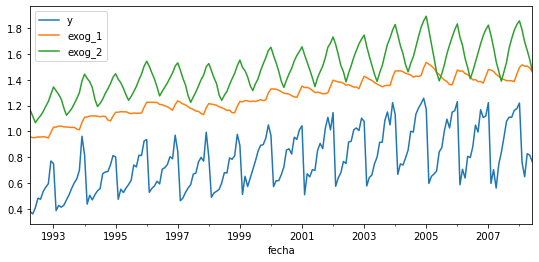

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

# ForecasterAutoregCustom without exogenous variables

In [4]:
def create_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors

In [5]:
# Create and fit forecaster
# ==============================================================================
from sklearn.pipeline import make_pipeline
forecaster = ForecasterAutoregCustom(
                    regressor      = make_pipeline(StandardScaler(), Ridge()),
                    fun_predictors = create_predictors,
                    window_size    = 20
              )
forecaster.fit(y=data_train.y)
forecaster

ForecasterAutoregCustom 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Predictors created with function: create_predictors 
Window size: 20 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-01-02 13:36:49 
Last fit date: 2022-01-02 13:36:49 
Skforecast version: 0.4.2 

Test error (mse): 0.025789429272728877


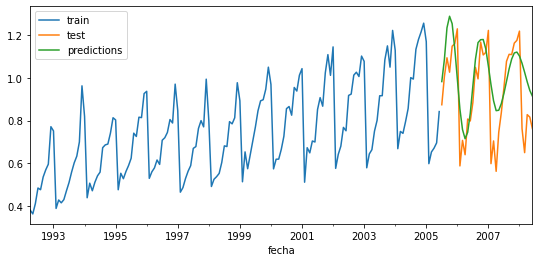

In [6]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [7]:
# Grid search hiperparameters
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}


results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

Number of models compared: 4


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: custom predictors 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.07673747042496534



,lags,params,metric,max_depth,n_estimators
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.076737,10,100
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.077523,10,50
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.078077,5,100
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.078175,5,50


In [8]:
# Predictors importance
# ==============================================================================
forecaster.get_feature_importance()

,feature,importance
0,custom_predictor_0,0.469656
1,custom_predictor_1,0.131669
2,custom_predictor_2,0.045522
3,custom_predictor_3,0.026149
4,custom_predictor_4,0.042438
5,custom_predictor_5,0.030298
6,custom_predictor_6,0.057705
7,custom_predictor_7,0.014640
8,custom_predictor_8,0.023036
9,custom_predictor_9,0.105772


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 1999-06-01 00:00:00 -- 2002-05-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2002-06-01 00:00:00 -- 2005-05-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2005-06-01 00:00:00 -- 2008-05-01 00:00:00
Data partition in fold: 3
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2008-06-01 00:00:00 -- 2008-06-01 00:00:00

[0.06821433]


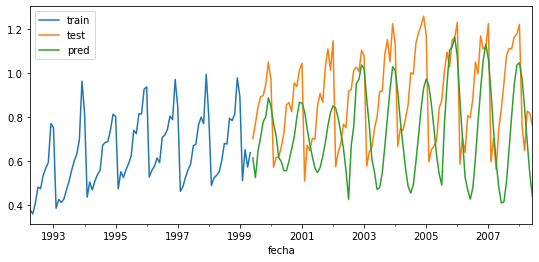

In [9]:
# Backtesting
# ==============================================================================
steps = 36
n_backtest = 36 * 3 + 1
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                                )
print(metrica)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax)
ax.legend();

In [10]:
predicciones_backtest

,pred
1999-06-01,0.615551
1999-07-01,0.525748
1999-08-01,0.646688
1999-09-01,0.707766
1999-10-01,0.779449
...,...
2008-02-01,0.973701
2008-03-01,0.839206
2008-04-01,0.686549
2008-05-01,0.542945


In [11]:
forecaster.fit(y=data_train.y)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3])
np.allclose(predicciones_backtest.pred, np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

True

# ForecasterAutoregCustom with 1 exogenous variables

In [12]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [13]:
forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )
forecaster

ForecasterAutoregCustom 
Regressor: LinearRegression() 
Predictors created with function: create_predictors 
Window size: 20 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2022-01-02 13:37:30 
Last fit date: None 
Skforecast version: 0.4.2 

Test error (mse): 1.1966787108671694e-29


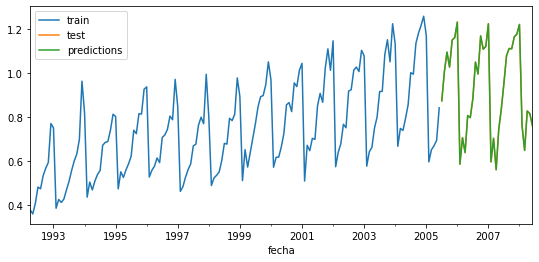

In [14]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=data_train.y, exog=data_train.exog_1)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test.exog_1)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [15]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        exog        = data_train.exog_1,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size    = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
               )

# Results grid Search
# ==============================================================================
results_grid.head(4)

Number of models compared: 4


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: custom predictors 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.06986196138399237



,lags,params,metric,max_depth,n_estimators
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.069862,5,50
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.071217,10,100
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.071439,10,50
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.071678,5,100


In [16]:
# Backtesting
# ==============================================================================
steps = 36
n_backtest = 36 * 3 + 1
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.y,
    exog       = data.exog_1,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metrica)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 1999-06-01 00:00:00 -- 2002-05-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2002-06-01 00:00:00 -- 2005-05-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2005-06-01 00:00:00 -- 2008-05-01 00:00:00
Data partition in fold: 3
    Training:   1992-04-01 00:00:00 -- 1999-05-01 00:00:00
    Validation: 2008-06-01 00:00:00 -- 2008-06-01 00:00:00

[9.1510579e-30]


In [17]:
# Verificar predicciones de backtesting
forecaster.fit(y=data_train.y, exog=data_train.exog_1)
predictions_1 = forecaster.predict(steps=steps, exog=data_test.exog_1[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps], exog=data_test.exog_1[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2], exog=data_test.exog_1[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3], exog=data_test.exog_1[steps*3:steps*4])
np.allclose(predicciones_backtest.pred, np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

True

# ForecasterAutoregCustom with multiple exogenous variables

In [18]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

Test error (mse): 0.00802480340550867


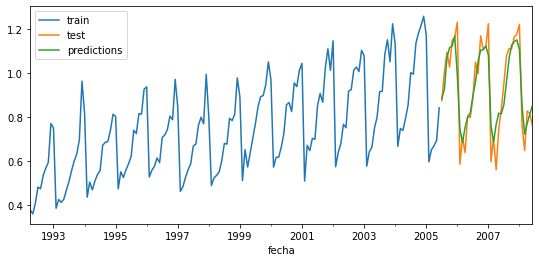

In [19]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )


forecaster.fit(y=data_train.y, exog=data_train[['exog_1', 'exog_2']])

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [20]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        exog        = data_train[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

/home/ximo/anaconda3/lib/python3.7/site-packages/skforecast/model_selection/model_selection.py:973: UserWarning: `lags_grid` ignored if forecaster is an instance of `ForecasterAutoregCustom`.
  '`lags_grid` ignored if forecaster is an instance of `ForecasterAutoregCustom`.'


Number of models compared: 4


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]

Refitting `forecaster` using the best found lags and parameters and the whole data set: 
  Lags: custom predictors 
  Parameters: {'max_depth': 10, 'n_estimators': 50}
  Backtesting metric: 0.05255335046720453



,lags,params,metric,max_depth,n_estimators
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.052553,10,50
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.053476,5,50
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.057799,10,100
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.057959,5,100


# Unit testing

In [21]:
# Unit test create_train_X_y
# ==============================================================================
import pytest
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.linear_model import LinearRegression



def create_predictors(y):
    '''
    Create first 5 lags of a time series.
    '''
    
    lags = y[-1:-6:-1]
    
    return lags 


def test_create_train_X_y_output_when_y_is_series_10_and_exog_is_None():
    '''
    Test the output of create_train_X_y when y=pd.Series(np.arange(10)) and 
    exog is None.
    '''
    forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 5
                )
    results = forecaster.create_train_X_y(y=pd.Series(np.arange(10)))
    expected = (pd.DataFrame(
                    data = np.array([[4, 3, 2, 1, 0],
                                    [5, 4, 3, 2, 1],
                                    [6, 5, 4, 3, 2],
                                    [7, 6, 5, 4, 3],
                                    [8, 7, 6, 5, 4]]),
                    index   = np.array([5, 6, 7, 8, 9]),
                    columns = ['custom_predictor_0', 'custom_predictor_1',
                               'custom_predictor_2', 'custom_predictor_3',
                               'custom_predictor_4']
                ),
                pd.Series(
                    np.array([5, 6, 7, 8, 9]),
                    index = np.array([5, 6, 7, 8, 9]))
               )     

    assert (results[0] == expected[0]).all().all()
    assert (results[1] == expected[1]).all()


def test_create_train_X_y_output_when_y_is_series_10_and_exog_is_series():
    '''
    Test the output of create_train_X_y when y=pd.Series(np.arange(10)) and 
    exog is a pandas series
    '''
    forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 5
                )
    results = forecaster.create_train_X_y(
                y = pd.Series(np.arange(10)),
                exog =  pd.Series(np.arange(100, 110), name='exog')
              )
    expected = (pd.DataFrame(
                    data = np.array([[4, 3, 2, 1, 0, 105],
                                    [5, 4, 3, 2, 1, 106],
                                    [6, 5, 4, 3, 2, 107],
                                    [7, 6, 5, 4, 3, 108],
                                    [8, 7, 6, 5, 4, 109]]),
                    index   = np.array([5, 6, 7, 8, 9]),
                    columns = ['custom_predictor_0', 'custom_predictor_1',
                               'custom_predictor_2', 'custom_predictor_3',
                               'custom_predictor_4', 'exog']
                ),
                pd.Series(
                    np.array([5, 6, 7, 8, 9]),
                    index = np.array([5, 6, 7, 8, 9]))
               )       

    assert (results[0] == expected[0]).all().all()
    assert (results[1] == expected[1]).all()

def test_create_train_X_y_output_when_y_is_series_10_and_exog_is_dataframe():
    '''
    Test the output of create_train_X_y when y=pd.Series(np.arange(10)) and 
    exog is a pandas dataframe with two columns.
    '''
    forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 5
                )
    results = forecaster.create_train_X_y(
                y = pd.Series(np.arange(10)),
                exog = pd.DataFrame({
                            'exog_1' : np.arange(100, 110),
                            'exog_2' : np.arange(1000, 1010)
                })
              )
    expected = (pd.DataFrame(
                    data = np.array([[4, 3, 2, 1, 0, 105, 1005],
                                  [5, 4, 3, 2, 1, 106, 1006],
                                  [6, 5, 4, 3, 2, 107, 1007],
                                  [7, 6, 5, 4, 3, 108, 1008],
                                  [8, 7, 6, 5, 4, 109, 1009]]),
                    index   = np.array([5, 6, 7, 8, 9]),
                    columns = ['custom_predictor_0', 'custom_predictor_1',
                               'custom_predictor_2', 'custom_predictor_3',
                               'custom_predictor_4', 'exog_1', 'exog_2']
                ),
                pd.Series(
                    np.array([5, 6, 7, 8, 9]),
                    index = np.array([5, 6, 7, 8, 9])
                )
               )        

    assert (results[0] == expected[0]).all().all()
    assert (results[1] == expected[1]).all()

    
def test_create_train_X_y_exception_when_y_and_exog_have_different_length():
    '''
    Test exception is raised when length of y and length of exog are different.
    '''
    forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 5
                )
    with pytest.raises(Exception):
        forecaster.fit(y=pd.Series(np.arange(50)), exog=pd.Series(np.arange(10)))
    with pytest.raises(Exception):
        forecaster.fit(y=pd.Series(np.arange(10)), exog=pd.Series(np.arange(50)))
    with pytest.raises(Exception):
        forecaster.fit(
            y=pd.Series(np.arange(10)),
            exog=pd.DataFrame(np.arange(50).reshape(25,2))
        )
        
def test_create_train_X_y_exception_when_y_and_exog_have_different_index():
    '''
    Test exception is raised when y and exog have different index.
    '''
    forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 5
                )
    with pytest.raises(Exception):
        forecaster.fit(
            y=pd.Series(np.arange(50)),
            exog=pd.Series(np.arange(10), index=np.arange(100, 110))
        )  
        
test_create_train_X_y_output_when_y_is_series_10_and_exog_is_None()
test_create_train_X_y_output_when_y_is_series_10_and_exog_is_series()
test_create_train_X_y_output_when_y_is_series_10_and_exog_is_dataframe()    
test_create_train_X_y_exception_when_y_and_exog_have_different_length()
test_create_train_X_y_exception_when_y_and_exog_have_different_index()

/home/ximo/anaconda3/lib/python3.7/site-packages/skforecast/utils/utils.py:344: UserWarning: `exog` has DatetimeIndex index but no frequency. The index is overwritten with a RangeIndex.
  ('`exog` has DatetimeIndex index but no frequency. The index is '


In [22]:
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.linear_model import LinearRegression


def create_predictors(y):
    '''
    Create first 5 lags of a time series.
    '''
    
    lags = y[-1:-6:-1]
    
    return lags  
    

def test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_True():
    '''
    Test output of _estimate_boot_interval when regressor is LinearRegression and
    1 step is predicted using in-sample residuals.
    '''
    forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(),
                        fun_predictors = create_predictors,
                        window_size    = 5
                 )
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = np.array([[20., 20.]])
    results = forecaster._estimate_boot_interval(steps=1, in_sample_residuals=True, n_boot=2)  
    assert results == approx(expected)

    
test_estimate_boot_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_True()

In [23]:
import numpy as np
import pandas as pd
from pytest import approx
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.linear_model import LinearRegression


def create_predictors(y):
    '''
    Create first 5 lags of a time series.
    '''
    
    lags = y[-1:-6:-1]
    
    return lags  



def test_fit_last_window_stored():
    '''
    Test that values of last window are stored after fitting.
    '''   
    forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(),
                        fun_predictors = create_predictors,
                        window_size    = 5
                    )
    forecaster.fit(y=pd.Series(np.arange(50)))
    expected = pd.Series(np.array([45, 46, 47, 48, 49]), index=[45, 46, 47, 48, 49])
    assert (forecaster.last_window == expected).all()
    
def test_in_sample_residuals_stored_when_fit_forecaster():
    '''
    Test that values of in_sample_residuals are stored after fitting.
    '''   
    forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(),
                        fun_predictors = create_predictors,
                        window_size    = 5
                    )

    forecaster.fit(y=pd.Series(np.arange(7)))
    expected = np.array([0, 0])
    results = forecaster.in_sample_residuals  
    assert results.values == approx(expected)
    
    
test_fit_last_window_stored()
test_in_sample_residuals_stored_when_fit_forecaster()

In [24]:
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


def create_predictors(y):
    '''
    Create first 5 lags of a time series.
    '''
    
    lags = y[-1:-6:-1]
    
    return lags  
    

def test_output_get_coef_when_regressor_is_LinearRegression():
    '''
    Test output of get_coef when regressor is LinearRegression with lags=3
    and it is trained with y=pd.Series(np.arange(5)).
    '''
    forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(),
                        fun_predictors = create_predictors,
                        window_size    = 5
                 )
    forecaster.fit(y=pd.Series(np.arange(7)))
    expected = pd.DataFrame({
                    'feature': ['custom_predictor_0', 'custom_predictor_1',
                                'custom_predictor_2', 'custom_predictor_3',
                                'custom_predictor_4'],
                    'coef': np.array([0.2, 0.2, 0.2, 0.2, 0.2])
                })
    results = forecaster.get_coef()
    assert (results['feature'] == expected['feature']).all()
    assert results['coef'].values == approx(expected['coef'].values)
    

def test_get_coef_when_regressor_is_RandomForest():
    '''
    Test output of get_coef when regressor is RandomForestRegressor with lags=3
    and it is trained with y=pd.Series(np.arange(5)).
    '''
    forecaster = ForecasterAutoregCustom(
                        regressor      = RandomForestRegressor(n_estimators=1, max_depth=2),
                        fun_predictors = create_predictors,
                        window_size    = 5
                 )
    forecaster.fit(y=pd.Series(np.arange(6)))
    expected = None
    results = forecaster.get_coef()
    assert results is expected
    

test_output_get_coef_when_regressor_is_LinearRegression()
test_get_coef_when_regressor_is_RandomForest()

/home/ximo/anaconda3/lib/python3.7/site-packages/skforecast/ForecasterAutoregCustom/ForecasterAutoregCustom.py:856: UserWarning: Impossible to access feature coefficients for regressor of type <class 'sklearn.ensemble._forest.RandomForestRegressor'>. This method is only valid when the regressor stores internally  the coefficients in the attribute `coef_`.
  f"Impossible to access feature coefficients for regressor of type {type(estimator)}. "


In [25]:
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.ensemble import RandomForestRegressor


def create_predictors(y):
    '''
    Create first 5 lags of a time series.
    '''
    
    lags = y[-1:-6:-1]
    
    return lags 


def test_output_get_feature_importance_when_regressor_is_RandomForest():
    '''
    '''
    forecaster = ForecasterAutoregCustom(
                        regressor      = RandomForestRegressor(n_estimators=1, max_depth=2, random_state=123),
                        fun_predictors = create_predictors,
                        window_size    = 5
                 )
    forecaster.fit(y=pd.Series(np.arange(10)))
    expected = np.array([0.82142857, 0., 0.17857143, 0., 0.])
    expected = pd.DataFrame({
                    'feature': ['custom_predictor_0', 'custom_predictor_1',
                                'custom_predictor_2', 'custom_predictor_3',
                                'custom_predictor_4'],
                    'importance': np.array([0.82142857, 0., 0.17857143, 0., 0.])
                })
    results = forecaster.get_feature_importance()
    assert (results['feature'] == expected['feature']).all()
    assert results['importance'].values == approx(expected['importance'].values)
    

def test_output_get_feature_importance_when_regressor_is_linear_model():
    '''
    '''
    forecaster = ForecasterAutoregCustom(
                            regressor      = LinearRegression(),
                            fun_predictors = create_predictors,
                            window_size    = 5
                    )
    forecaster.fit(y=pd.Series(np.arange(6)))
    expected = None
    results = forecaster.get_feature_importance()
    assert results is expected
    

test_output_get_feature_importance_when_regressor_is_RandomForest()
test_output_get_feature_importance_when_regressor_is_linear_model()

/home/ximo/anaconda3/lib/python3.7/site-packages/skforecast/ForecasterAutoregCustom/ForecasterAutoregCustom.py:894: UserWarning: Impossible to access feature importance for regressor of type <class 'sklearn.linear_model._base.LinearRegression'>. This method is only valid when the regressor stores internally  the feature importance in the attribute `feature_importances_`.
  f"Impossible to access feature importance for regressor of type {type(estimator)}. "


In [26]:
import pytest
import pandas as pd
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.linear_model import LinearRegression



def create_predictors(y):
    '''
    Create first 5 lags of a time series.
    '''
    
    lags = y[-1:-6:-1]
    
    return lags  


def test_init_exception_when_window_size_argument_is_string():
   
   with pytest.raises(Exception):
        forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(),
                        fun_predictors = create_predictors,
                        window_size    = '5'
                    )

def test_init_exception_when_fun_predictors_argument_is_string():
   
   with pytest.raises(Exception):
        forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(),
                        fun_predictors = 'create_predictors',
                        window_size    = 5
                    )
        

test_init_exception_when_window_size_argument_is_string()
test_init_exception_when_fun_predictors_argument_is_string()

In [27]:
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.linear_model import LinearRegression



def create_predictors(y):
    '''
    Create first 5 lags of a time series.
    '''
    
    lags = y[-1:-6:-1]
    
    return lags  
    

def test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_True():
    '''
    Test output when regressor is LinearRegression and one step ahead is predicted
    using in sample residuals.
    '''
    forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(),
                        fun_predictors = create_predictors,
                        window_size    = 5
                 )
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = pd.DataFrame(
                   np.array([[10., 20., 20.]]),
                   columns = ['pred', 'lower_bound', 'upper_bound'],
                   index = pd.RangeIndex(start=10, stop=11, step=1)
               )
    results = forecaster.predict_interval(steps=1, in_sample_residuals=True, n_boot=2)  
    pd.testing.assert_frame_equal(results, expected)


def test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_True():
    '''
    Test output when regressor is LinearRegression and two step ahead is predicted
    using in sample residuals.
    '''
    forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(),
                        fun_predictors = create_predictors,
                        window_size    = 5
                    )    
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.in_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = pd.DataFrame(
                   np.array([[10., 20., 20.],
                         [11., 23., 23.]]),
                   columns = ['pred', 'lower_bound', 'upper_bound'],
                   index = pd.RangeIndex(start=10, stop=12, step=1)
               )
    results = forecaster.predict_interval(steps=2, in_sample_residuals=True, n_boot=2)  
    pd.testing.assert_frame_equal(results, expected)
    
    
def test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_False():
    '''
    Test output when regressor is LinearRegression and one step ahead is predicted
    using out sample residuals.
    '''
    forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(),
                        fun_predictors = create_predictors,
                        window_size    = 5
                    )
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.out_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = pd.DataFrame(
                   np.array([[10., 20., 20.]]),
                   columns = ['pred', 'lower_bound', 'upper_bound'],
                   index = pd.RangeIndex(start=10, stop=11, step=1)
               )
    results = forecaster.predict_interval(steps=1, in_sample_residuals=False, n_boot=2)  
    pd.testing.assert_frame_equal(results, expected)

    
def test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_False():
    '''
    Test output when regressor is LinearRegression and two step ahead is predicted
    using out sample residuals.
    '''
    forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(),
                        fun_predictors = create_predictors,
                        window_size    = 5
                    )
    forecaster.fit(y=pd.Series(np.arange(10)))
    forecaster.out_sample_residuals = np.full_like(forecaster.in_sample_residuals, fill_value=10)
    expected = pd.DataFrame(
                   np.array([[10., 20., 20.],
                         [11., 23., 23.]]),
                   columns = ['pred', 'lower_bound', 'upper_bound'],
                   index = pd.RangeIndex(start=10, stop=12, step=1)
               )
    results = forecaster.predict_interval(steps=2, in_sample_residuals=False)  
    pd.testing.assert_frame_equal(results, expected)

test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_True()
test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_True()
test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_1_in_sample_residuals_is_False()
test_predict_interval_output_when_forecaster_is_LinearRegression_steps_is_2_in_sample_residuals_is_False()

In [28]:
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.linear_model import LinearRegression


def create_predictors(y):
    '''
    Create first 5 lags of a time series.
    '''
    
    lags = y[-1:-6:-1]
    
    return lags 


def test_predict_output_when_regressor_is_LinearRegression():
    '''
    Test predict output when using LinearRegression as regressor.
    '''
    forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(),
                        fun_predictors = create_predictors,
                        window_size    = 5
                    )
    forecaster.fit(y=pd.Series(np.arange(50)))
    results = forecaster.predict(steps=5)
    expected = pd.Series(
                data = np.array([50., 51., 52., 53., 54.]),
                index = pd.RangeIndex(start=50, stop=55, step=1),
                name = 'pred'
               )
    pd.testing.assert_series_equal(results, expected)

test_predict_output_when_regressor_is_LinearRegression()

In [29]:
# Unit test _recursive_predict
# ==============================================================================

from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.linear_model import LinearRegression

def create_predictors(y):
    '''
    Create first 5 lags of a time series.
    '''
    
    lags = y[-1:-6:-1]
    
    return lags  

def test_recursive_predict_output_when_regressor_is_LinearRegression():
    '''
    Test _recursive_predict output when using LinearRegression as regressor.
    '''
    forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(),
                        fun_predictors = create_predictors,
                        window_size    = 5
                )
    forecaster.fit(y=pd.Series(np.arange(50)))
    predictions = forecaster._recursive_predict(
                    steps = 5,
                    last_window = forecaster.last_window.values,
                    exog = None
                  )
    expected = np.array([50., 51., 52., 53., 54.])
    assert (predictions == approx(expected))
    
test_recursive_predict_output_when_regressor_is_LinearRegression()

In [30]:
import pytest
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.linear_model import LinearRegression


def create_predictors(y):
    '''
    Create first 5 lags of a time series.
    '''
    
    lags = y[-1:-6:-1]
    
    return lags   
    

def test_set_out_sample_residuals_exception_when_residuals_is_not_array():
    '''
    Test exception is raised when residuals argument is not numpy array.
    '''
    forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(),
                        fun_predictors = create_predictors,
                        window_size    = 5
                 )
    with pytest.raises(Exception):
        forecaster.set_out_sample_residuals(residuals=[1, 2, 3])
        
        
def test_set_out_sample_residuals_when_residuals_length_is_less_than_1000_and_no_append():
    '''
    Test residuals stored when its length is less than 1000 and append is False.
    '''
    forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(),
                        fun_predictors = create_predictors,
                        window_size    = 5
                 )
    forecaster.set_out_sample_residuals(residuals=np.arange(10), append=False)
    expected = np.arange(10)
    results = forecaster.out_sample_residuals
    assert (results == expected).all()
    
def test_set_out_sample_residuals_when_residuals_length_is_less_than_1000_and_append():
    '''
    Test residuals stored when its length is less than 1000 and append is True.
    '''
    forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(),
                        fun_predictors = create_predictors,
                        window_size    = 5
                 )
    forecaster.set_out_sample_residuals(residuals=np.arange(10), append=True)
    forecaster.set_out_sample_residuals(residuals=np.arange(10), append=True)
    expected = np.hstack([np.arange(10), np.arange(10)])
    results = forecaster.out_sample_residuals
    assert (results == expected).all()
    

def test_set_out_sample_residuals_when_residuals_length_is_greater_than_1000():
    '''
    Test residuals stored when its length is greater than 1000.
    '''
    forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(),
                        fun_predictors = create_predictors,
                        window_size    = 5
                 )
    forecaster.set_out_sample_residuals(residuals=np.arange(2000))
    assert len(forecaster.out_sample_residuals) == 1000
    

test_set_out_sample_residuals_exception_when_residuals_is_not_array()
test_set_out_sample_residuals_when_residuals_length_is_less_than_1000_and_no_append()
test_set_out_sample_residuals_when_residuals_length_is_less_than_1000_and_append()
test_set_out_sample_residuals_when_residuals_length_is_greater_than_1000()

In [31]:
import pandas as pd
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.linear_model import LinearRegression


def create_predictors(y):
    '''
    Create first 5 lags of a time series.
    '''
    
    lags = y[-1:-6:-1]
    
    return lags 

def test_set_paramns():
    
    forecaster = ForecasterAutoregCustom(
                        regressor      = LinearRegression(fit_intercept=True),
                        fun_predictors = create_predictors,
                        window_size    = 5
                 )
    new_params = {'fit_intercept': False}
    forecaster.set_params(**new_params)
    expected = {'copy_X': True,
                 'fit_intercept': False,
                 'n_jobs': None,
                 'normalize': 'deprecated',
                 'positive': False
                }
    results = forecaster.regressor.get_params()
    assert results == expected
    
test_set_paramns()